In [ ]:
!pip install mysql-connector-python

In [ ]:
import mysql.connector

connection = mysql.connector.connect(
    host="127.0.0.1",
    user="root",
    password="     ",
    database="preday50")
cursor = connection.cursor()

In [ ]:
import pandas as pd

In [ ]:
cursor.execute("""
CREATE TABLE IF NOT EXISTS customers(
    id INT PRIMARY KEY,
    name VARCHAR(100),
    city VARCHAR(100)
) ENGINE=InnoDB;
""")

cursor.execute("""
INSERT INTO customers VALUES
    (1, 'Alice', 'Hanoi'),
    (2, 'Bob', 'Ho Chi Minh'),
    (3, 'Charlie', 'Hanoi')
;
""")
connection.commit()

cursor.execute("""
CREATE TABLE IF NOT EXISTS orders(
    id INT PRIMARY KEY,
    customer_id INT,
    order_date DATE,
    total INT
)ENGINE=InnoDB;
""")

cursor.execute("""
INSERT INTO orders VALUES
    (1, 1, '2024-01-10', 500),
    (2, 1, '2024-03-01', 800),
    (3, 2, '2024-02-20', 1200),
    (4, 3, '2024-01-15', 200)
;
""")
connection.commit()

cursor.execute("""
CREATE TABLE IF NOT EXISTS products(
    id INT PRIMARY KEY,
    name VARCHAR(100),
    price INT
)ENGINE=InnoDB;
""")

cursor.execute("""
INSERT INTO products VALUES
    (1, 'Laptop', 1500),
    (2, 'Mouse', 50),
    (3, 'Keyboard', 100),
    (4, 'Monitor', 300)
;
""")
connection.commit()

cursor.execute("""
CREATE TABLE IF NOT EXISTS order_items(
    id INT PRIMARY KEY,
    order_id INT,
    product_id INT,
    quantity INT
)ENGINE=InnoDB;
""")

cursor.execute("""
INSERT INTO order_items VALUES
    (1, 1, 2, 2),
    (2, 1, 3, 1),
    (3, 2, 1, 1),
    (4, 2, 4, 1),
    (5, 3, 1, 1)
;
""")
connection.commit()

cursor.execute("""
CREATE TABLE IF NOT EXISTS employees(
    id INT PRIMARY KEY,
    name VARCHAR(100),
    department VARCHAR(100)
)ENGINE=InnoDB;
""")

cursor.execute("""
INSERT INTO employees VALUES
    (1, 'David', 'Sales'),
    (2, 'Emma', 'Support'),
    (3, 'Frank', 'Sales')
;
""")
connection.commit()

cursor.execute("""
CREATE TABLE IF NOT EXISTS order_assignments(
    id INT PRIMARY KEY,
    order_id INT,
    employee_id INT
)ENGINE=InnoDB;
""")

cursor.execute("""
INSERT INTO order_assignments VALUES
    (1, 1, 1),
    (2, 2, 3),
    (3, 3, 2)
;
""")
connection.commit()

In [ ]:
# Tạo trigger để ghi log vào bảng order_logs mỗi khi đơn hàng bị xoá khỏi bảng orders

query= """
CREATE TABLE IF NOT EXISTS order_logs (
    id INT AUTO_INCREMENT PRIMARY KEY,
    log_message TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
;"""
cursor.execute(query)

In [ ]:
query="""
CREATE TRIGGER log_order_delete
AFTER DELETE ON orders
FOR EACH ROW
BEGIN
    INSERT INTO order_logs(log_message)
    VALUES (CONCAT('Delete order ID:', OLD.id, '-total:', OLD.total));
END
;"""

cursor.execute(query)
connection.commit()

In [ ]:
# TEST TRIGGER
query="""
DELETE FROM orders
WHERE id=1;"""
cursor.execute(query)

In [ ]:
query=""" SELECT * FROM order_logs"""
cursor.execute(query)
result = cursor.fetchall()
for row in result:
    print(row)

In [ ]:
# Tạo trigger trên bảng order_items để tự động cập nhật tổng tiền của đơn hàng trong bảng orders khi thêm dòng sản phẩm mới

query="""
CREATE TABLE update_product_logs(
    id INT AUTO_INCREMENT PRIMARY KEY,
    log_message TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
)
;"""
cursor.execute(query)


In [ ]:
query= """
CREATE TRIGGER update_order_total2
AFTER INSERT ON order_items
FOR EACH ROW
BEGIN
    UPDATE orders
    SET total = total + NEW.quantity * (SELECT price FROM products WHERE id= NEW.product_id)
    WHERE order_id = NEW.order_id;

    INSERT INTO update_product_logs(log_message)
    VALUES (CONCAT('NEW order_id:', NEW.order_id, '-product_id:', NEW.product_id, '-quantity:', NEW.quantity)) ;
END
;"""

cursor.execute(query)
connection.commit()

In [ ]:
# TEST TRIGGER
query= """
INSERT INTO order_items VALUES
    (6,2,5,1)
;"""
cursor.execute(query)
connection.commit()

In [ ]:
# TEST TRIGGER
query="""
INSERT INTO products VALUES
    (5,'Main', 200)
;"""
cursor.execute(query)
connection.commit()

In [ ]:
query="""
SELECT * FROM update_product_logs
;"""

cursor.execute(query)
result= cursor.fetchall()
for row in result:
    print(row)

In [ ]:
# Tạo trigger BEFORE UPDATE trên bảng products để huỷ cập nhật nếu giá mới vượt quá 1000
query = """
CREATE TABLE prevent_price_products_logs(
    id INT AUTO_INCREMENT PRIMARY KEY,
    log_message TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP)
;"""
cursor.execute(query)

In [ ]:
query="""
CREATE TRIGGER prevent_price_products
BEFORE UPDATE ON products
FOR EACH ROW
BEGIN
   IF NEW.price >1000 THEN
       SIGNAL SQLSTATE '45000'
       SET MESSAGE_TEXT= 'Price too hight';
    END IF;

    INSERT INTO prevent_price_products_logs(log_message) VALUES
        (CONCAT('Product ID:', NEW.id, '- Old Price:', OLD.price, '- New Price:', NEW.price));
END
;"""
cursor.execute(query)
connection.commit()

In [ ]:
# TEST TRIGGER

query="""
UPDATE products
SET price = 55
WHERE id = 2;"""
cursor.execute(query)
connection.commit()

In [ ]:
query = "SELECT * FROM prevent_price_products_logs"
cursor.execute(query)
result= cursor.fetchall()
for row in result:
    print(row)

In [ ]:
# Mỗi khi xoá khách hàng, ghi lại thông tin vào bảng customers_deleted để lưu trữ

query= """
CREATE TABLE customers_deleted_logs(
    id INT,
    name VARCHAR(50),
    city VARCHAR(50),
    deleted_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP)
;"""
cursor.execute(query)

In [ ]:
query="""
CREATE TRIGGER customers_deleted
BEFORE DELETE ON customers
FOR EACH ROW
BEGIN
    INSERT INTO customers_deleted_logs(id, name, city)
    VALUES(OLD.id, OLD.name, OLD.city);
END
;"""
cursor.execute(query)
connection.commit()

In [ ]:
# TEST TRIGGER
query="DELETE FROM orders WHERE customer_id = 1;"""
cursor.execute(query)

In [ ]:
query="DELETE FROM customers WHERE id = 1;"""
cursor.execute(query)

In [ ]:
query="SELECT * FROM customers_deleted_logs;"""
cursor.execute(query)
result=cursor.fetchall()
for row in result:
    print(row)

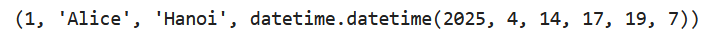

In [ ]:
# Ghi log vào bảng order_alerts khi khách hàng từ “Hanoi” đặt đơn hàng có tổng lớn hơn 1000
query="""
CREATE TABLE IF NOT EXISTS order_alerts_logs(
    id INT AUTO_INCREMENT PRIMARY KEY,
    alert_message TEXT,
    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP)
;"""
cursor.execute(query)

In [ ]:
query= """
CREATE TRIGGER order_alerts
AFTER INSERT ON orders
FOR EACH ROW
BEGIN
    IF NEW.total>1000 AND
        (SELECT city FROM customers WHERE id= NEW.customer_id) = "Hanoi"
        THEN
        INSERT INTO order_alerts_logs(alert_message) VALUES
        (CONCAT('Alert: High value order by Hanoi customer ID:', NEW.customer_id, 'Total:', NEW.total));
    END IF;
END
;"""

cursor.execute(query)


In [ ]:
# TEST TRIGGER
query= """
INSERT INTO orders(id, customer_id, order_date, total) VALUES
    (8,3,'2024-10-30', 1300)
;"""
cursor.execute(query)

In [ ]:
query="SELECT * FROM order_alerts_logs;"
cursor.execute(query)
result=cursor.fetchall()
for row in result:
    print(row)

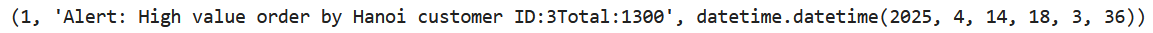